**1. Importing the dependencies**

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

# Trực quan hóa dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb
# Tiền xử lý dữ liệu
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

# Chia dữ liệu và đánh giá mô hình
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV, validation_curve

# Các thuật toán phân loại
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Các thuật toán hồi quy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

# Đánh giá mô hình
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, precision_recall_curve,
    mean_squared_error, mean_absolute_error, r2_score
)

# Xử lý cảnh báo
import warnings
warnings.simplefilter(action="ignore")

# Lưu và tải mô hình
import pickle


In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 28. Model with Survival Analysis

In [4]:
from google.colab import files
uploaded = files.upload()

train_df = pd.read_csv('train_survival.csv')
test_df = pd.read_csv('test_survival.csv')

# Tách các đặc trưng và giá trị churn từ các file
X_train = train_df.drop(columns=['churn_value'])
y_train = train_df['churn_value']

X_test = test_df.drop(columns=['churn_value'])
y_test = test_df['churn_value']

Saving Merged_Churn_Dataset.csv to Merged_Churn_Dataset.csv
Saving survival_features_test.csv to survival_features_test.csv
Saving survival_features_train.csv to survival_features_train.csv
Saving test_survival.csv to test_survival.csv
Saving train_survival.csv to train_survival.csv


In [5]:
survival_train = pd.read_csv("survival_features_train.csv")
survival_test = pd.read_csv("survival_features_test.csv")

# Merge lại vào X_train, X_test bằng index (thứ tự hàng)
X_train_final = pd.concat([X_train.reset_index(drop=True), survival_train], axis=1)
X_test_final = pd.concat([X_test.reset_index(drop=True), survival_test], axis=1)


In [6]:
X_train_final

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,city,zip_code,total_population,latitude,longitude,New_total_services,New_flag_auto_payment,New_avg_service_fee,New_tenure_year_2,New_tenure_year_3,New_tenure_year_4,New_tenure_year_5,New_tenure_year_6,New_contract_type_1,New_contract_type_2,New_family_size_2,New_family_size_3,hazard_score,baseline_hazard,hazard_group,survival_prob_3m,survival_prob_6m,survival_prob_12m
0,0,-0.071,0,0,1,0,0.000,60,1,1,1,0.083,1,2,2.667,1,1,0,0,0,1,1,2,0,1,1,0.437,-0.270,1.205,0.000,0.000,0.474,349,0.531,-0.369,0.400,-0.444,1,1,0.448,False,False,False,True,False,False,False,True,False,-5.730,63.329,Low,0.000,0.000,0.000
1,1,-0.071,0,0,0,1,3.000,12,0,1,0,-0.708,0,4,0.000,0,0,0,0,0,0,0,3,2,0,0,-0.938,-0.208,-0.349,0.000,0.000,-0.174,554,-1.080,0.870,-0.510,0.371,0,1,-0.859,False,False,False,False,False,False,True,True,False,-3.743,0.139,Medium-Low,0.817,0.750,0.577
2,0,-0.393,0,0,0,0,0.000,2,1,1,0,0.333,1,0,0.000,1,0,1,0,0,0,0,2,0,1,2,0.186,0.461,-0.371,0.000,0.000,-0.295,989,-0.016,-0.285,-0.160,-0.300,1,0,0.126,False,False,False,False,False,False,False,False,False,5.136,0.028,High,0.947,0.922,0.838
3,1,-0.393,0,0,1,0,0.000,33,1,1,0,0.542,1,3,2.333,1,0,1,0,1,1,1,0,1,0,1,0.081,0.955,0.313,0.000,0.000,1.080,368,-0.717,0.706,-0.496,0.353,1,1,-0.008,False,True,False,False,False,True,False,True,False,-2.731,1.658,Medium-Low,0.098,0.028,0.001
4,0,0.250,0,0,0,1,1.000,14,1,1,1,0.208,1,4,0.000,1,0,0,1,0,0,0,2,0,1,3,0.288,0.913,-0.068,0.000,0.000,0.238,52,-0.029,-0.496,-0.244,-0.297,1,0,0.257,True,False,False,False,False,False,False,True,False,2.949,0.177,High,0.773,0.713,0.504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0,0.107,0,0,1,1,2.000,22,0,1,0,-0.708,0,0,2.667,0,0,0,0,0,0,0,3,1,0,0,-0.913,0.826,-0.278,0.000,0.000,0.532,952,-0.879,0.359,-0.576,0.419,0,1,-0.793,True,False,False,False,False,True,False,False,True,-4.871,0.446,Medium-Low,0.535,0.438,0.163
5630,0,-0.750,1,0,1,0,0.000,42,1,1,1,0.417,1,0,0.333,0,0,0,0,1,1,1,2,0,1,2,0.439,-0.590,0.824,0.000,0.000,-0.102,170,0.774,-0.513,1.179,-0.718,1,0,0.451,False,False,True,False,False,False,False,True,False,-0.868,5.513,Medium-High,0.001,0.000,0.000
5631,1,0.107,0,0,0,0,0.000,20,1,1,1,0.333,1,4,0.000,0,0,0,0,1,0,0,2,0,1,2,0.274,-0.792,0.100,0.000,0.000,-0.334,290,-0.554,0.375,-0.510,0.406,1,0,0.240,True,False,False,False,False,False,False,False,False,2.621,0.338,High,0.619,0.504,0.237
5632,0,-0.143,0,0,1,1,3.000,24,0,1,1,-0.708,0,0,2.333,0,0,0,0,0,0,0,3,2,0,3,-0.840,-0.079,-0.243,0.000,0.000,0.086,363,0.780,-0.420,0.917,-0.676,0,0,-0.606,True,False,False,False,False,False,True,False,True,-6.454,0.550,Low,0.465,0.350,0.098


In [7]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler

In [8]:
from sklearn.preprocessing import RobustScaler
import pandas as pd

# One-hot encoding cho cột 'hazard_group' bằng pd.get_dummies
X_train_final = pd.get_dummies(X_train_final, columns=['hazard_group'], drop_first=False)
X_test_final = pd.get_dummies(X_test_final, columns=['hazard_group'], drop_first=False)

# Sử dụng RobustScaler cho các cột số liệu
columns_to_scale = ['hazard_score', 'baseline_hazard', 'survival_prob_3m', 'survival_prob_6m', 'survival_prob_12m']

# Khởi tạo RobustScaler
scaler = RobustScaler()

# Chuẩn hóa các cột cho cả train và test
X_train_final[columns_to_scale] = scaler.fit_transform(X_train_final[columns_to_scale])
X_test_final[columns_to_scale] = scaler.transform(X_test_final[columns_to_scale])



In [9]:
X_train_final.head()

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,city,zip_code,total_population,latitude,longitude,New_total_services,New_flag_auto_payment,New_avg_service_fee,New_tenure_year_2,New_tenure_year_3,New_tenure_year_4,New_tenure_year_5,New_tenure_year_6,New_contract_type_1,New_contract_type_2,New_family_size_2,New_family_size_3,hazard_score,baseline_hazard,survival_prob_3m,survival_prob_6m,survival_prob_12m,hazard_group_High,hazard_group_Low,hazard_group_Medium-High,hazard_group_Medium-Low
0,0,-0.071,0,0,1,0,0.000,60,1,1,1,0.083,1,2,2.667,1,1,0,0,0,1,1,2,0,1,1,0.437,-0.270,1.205,0.000,0.000,0.474,349,0.531,-0.369,0.400,-0.444,1,1,0.448,False,False,False,True,False,False,False,True,False,-0.617,2.112,-0.273,-0.153,-0.011,False,True,False,False
1,1,-0.071,0,0,0,1,3.000,12,0,1,0,-0.708,0,4,0.000,0,0,0,0,0,0,0,3,2,0,0,-0.938,-0.208,-0.349,0.000,0.000,-0.174,554,-1.080,0.870,-0.510,0.371,0,1,-0.859,False,False,False,False,False,False,True,True,False,-0.360,-0.027,0.666,0.765,0.828,False,False,False,True
2,0,-0.393,0,0,0,0,0.000,2,1,1,0,0.333,1,0,0.000,1,0,1,0,0,0,0,2,0,1,2,0.186,0.461,-0.371,0.000,0.000,-0.295,989,-0.016,-0.285,-0.160,-0.300,1,0,0.126,False,False,False,False,False,False,False,False,False,0.786,-0.030,0.816,0.977,1.208,True,False,False,False
3,1,-0.393,0,0,1,0,0.000,33,1,1,0,0.542,1,3,2.333,1,0,1,0,1,1,1,0,1,0,1,0.081,0.955,0.313,0.000,0.000,1.080,368,-0.717,0.706,-0.496,0.353,1,1,-0.008,False,True,False,False,False,True,False,True,False,-0.230,0.025,-0.161,-0.118,-0.010,False,False,False,True
4,0,0.250,0,0,0,1,1.000,14,1,1,1,0.208,1,4,0.000,1,0,0,1,0,0,0,2,0,1,3,0.288,0.913,-0.068,0.000,0.000,0.238,52,-0.029,-0.496,-0.244,-0.297,1,0,0.257,True,False,False,False,False,False,False,True,False,0.504,-0.025,0.616,0.721,0.722,True,False,False,False


In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd

# Chuyển đổi categorical sang numeric bằng one-hot encoding
X_train_encoded = pd.get_dummies(X_train_final, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_final, drop_first=True)

# Đảm bảo train và test có cùng số lượng cột
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Số cụm khách hàng
n_clusters = 4

# KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_train_final['kmeans_cluster'] = kmeans.fit_predict(X_train_encoded)
X_test_final['kmeans_cluster'] = kmeans.predict(X_test_encoded)

# CatBoost model
catboost_model = CatBoostClassifier(verbose=False, random_state=42)
catboost_model.fit(X_train_encoded, y_train)

# Optimal threshold
def find_optimal_threshold(model, X_val, y_val):
    y_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

optimal_threshold = find_optimal_threshold(catboost_model, X_train_encoded, y_train)

# Đánh giá mô hình
y_proba_test = catboost_model.predict_proba(X_test_encoded)[:, 1]
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)

# Kết quả
print("\n📊 Final CatBoost Model (with K-Means) Performance")
print(classification_report(y_test, y_pred_test))
print(f"🎯 Optimal Threshold: {optimal_threshold:.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_proba_test):.4f}")


📊 Final CatBoost Model (with K-Means) Performance
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1035
           1       0.73      0.71      0.72       374

    accuracy                           0.85      1409
   macro avg       0.81      0.80      0.81      1409
weighted avg       0.85      0.85      0.85      1409

🎯 Optimal Threshold: 0.4373
AUC Score: 0.9135


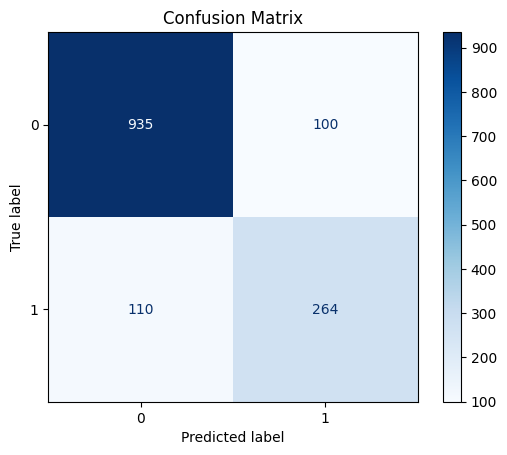

Final CatBoost Model Performance on Test Set
---------------------------------------------
Accuracy : 0.8510
Recall   : 0.7059
Precision: 0.7253
F1 Score : 0.7154
AUC      : 0.9135


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)
print("Final CatBoost Model Performance on Test Set")
print("---------------------------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")

In [12]:
X_train_encoded

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,city,zip_code,total_population,latitude,longitude,New_total_services,New_flag_auto_payment,New_avg_service_fee,New_tenure_year_2,New_tenure_year_3,New_tenure_year_4,New_tenure_year_5,New_tenure_year_6,New_contract_type_1,New_contract_type_2,New_family_size_2,New_family_size_3,hazard_score,baseline_hazard,survival_prob_3m,survival_prob_6m,survival_prob_12m,hazard_group_High,hazard_group_Low,hazard_group_Medium-High,hazard_group_Medium-Low
0,0,-0.071,0,0,1,0,0.000,60,1,1,1,0.083,1,2,2.667,1,1,0,0,0,1,1,2,0,1,1,0.437,-0.270,1.205,0.000,0.000,0.474,349,0.531,-0.369,0.400,-0.444,1,1,0.448,False,False,False,True,False,False,False,True,False,-0.617,2.112,-0.273,-0.153,-0.011,False,True,False,False
1,1,-0.071,0,0,0,1,3.000,12,0,1,0,-0.708,0,4,0.000,0,0,0,0,0,0,0,3,2,0,0,-0.938,-0.208,-0.349,0.000,0.000,-0.174,554,-1.080,0.870,-0.510,0.371,0,1,-0.859,False,False,False,False,False,False,True,True,False,-0.360,-0.027,0.666,0.765,0.828,False,False,False,True
2,0,-0.393,0,0,0,0,0.000,2,1,1,0,0.333,1,0,0.000,1,0,1,0,0,0,0,2,0,1,2,0.186,0.461,-0.371,0.000,0.000,-0.295,989,-0.016,-0.285,-0.160,-0.300,1,0,0.126,False,False,False,False,False,False,False,False,False,0.786,-0.030,0.816,0.977,1.208,True,False,False,False
3,1,-0.393,0,0,1,0,0.000,33,1,1,0,0.542,1,3,2.333,1,0,1,0,1,1,1,0,1,0,1,0.081,0.955,0.313,0.000,0.000,1.080,368,-0.717,0.706,-0.496,0.353,1,1,-0.008,False,True,False,False,False,True,False,True,False,-0.230,0.025,-0.161,-0.118,-0.010,False,False,False,True
4,0,0.250,0,0,0,1,1.000,14,1,1,1,0.208,1,4,0.000,1,0,0,1,0,0,0,2,0,1,3,0.288,0.913,-0.068,0.000,0.000,0.238,52,-0.029,-0.496,-0.244,-0.297,1,0,0.257,True,False,False,False,False,False,False,True,False,0.504,-0.025,0.616,0.721,0.722,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0,0.107,0,0,1,1,2.000,22,0,1,0,-0.708,0,0,2.667,0,0,0,0,0,0,0,3,1,0,0,-0.913,0.826,-0.278,0.000,0.000,0.532,952,-0.879,0.359,-0.576,0.419,0,1,-0.793,True,False,False,False,False,True,False,False,True,-0.506,-0.016,0.342,0.384,0.226,False,False,False,True
5630,0,-0.750,1,0,1,0,0.000,42,1,1,1,0.417,1,0,0.333,0,0,0,0,1,1,1,2,0,1,2,0.439,-0.590,0.824,0.000,0.000,-0.102,170,0.774,-0.513,1.179,-0.718,1,0,0.451,False,False,True,False,False,False,False,True,False,0.011,0.155,-0.272,-0.153,-0.011,False,False,True,False
5631,1,0.107,0,0,0,0,0.000,20,1,1,1,0.333,1,4,0.000,0,0,0,0,1,0,0,2,0,1,2,0.274,-0.792,0.100,0.000,0.000,-0.334,290,-0.554,0.375,-0.510,0.406,1,0,0.240,True,False,False,False,False,False,False,False,False,0.461,-0.020,0.439,0.464,0.334,True,False,False,False
5632,0,-0.143,0,0,1,1,3.000,24,0,1,1,-0.708,0,0,2.333,0,0,0,0,0,0,0,3,2,0,3,-0.840,-0.079,-0.243,0.000,0.000,0.086,363,0.780,-0.420,0.917,-0.676,0,0,-0.606,True,False,False,False,False,False,True,False,True,-0.710,-0.013,0.262,0.276,0.131,False,True,False,False


In [13]:
X_train_final_csv = X_train_encoded.copy()
X_train_final_csv.to_csv('train_final_no_label.csv', index=False)

# Xuất file CSV đầy đủ cho tập test:
X_test_final_csv = X_test_encoded.copy()
X_test_final_csv.to_csv('test_final_no_label.csv', index=False)

## 29. Hyper Tuning

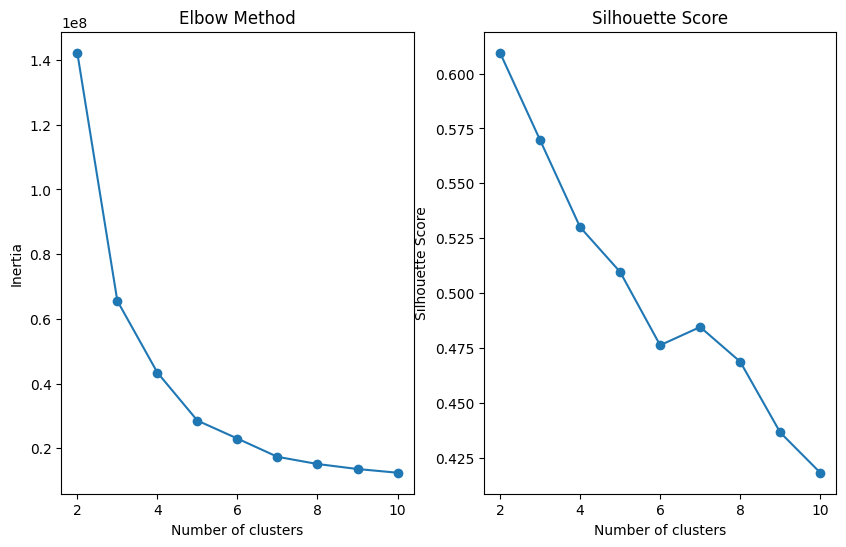

([142232704.24020547,
  65576727.31821491,
  43420138.0431325,
  28573111.227476563,
  23017622.957683578,
  17381638.733738724,
  15155202.470222447,
  13608241.02486671,
  12463762.220994415],
 [np.float64(0.6095040660178654),
  np.float64(0.5697170982720177),
  np.float64(0.5300190460479498),
  np.float64(0.5095977886305136),
  np.float64(0.47618510436281475),
  np.float64(0.4844761548063705),
  np.float64(0.4686720258517085),
  np.float64(0.4364173271859461),
  np.float64(0.418068117818266)])

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, silhouette_score


X_train_encoded = pd.get_dummies(X_train_final, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_final, drop_first=True)

# Đảm bảo train và test có cùng số lượng cột
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Sử dụng Elbow Method để tìm số cụm tốt
def find_optimal_clusters(X_train):
    inertia = []
    silhouette_scores = []
    for n_clusters in range(2, 11):  # Kiểm tra từ 2 đến 10 cụm
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))

    # Vẽ đồ thị Elbow Method
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, 11), inertia, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

    # Vẽ đồ thị Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')

    plt.show()

    return inertia, silhouette_scores

# Tìm số cụm tối ưu
find_optimal_clusters(X_train_encoded)

In [15]:
n_clusters = 3

# KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_train_final['kmeans_cluster'] = kmeans.fit_predict(X_train_encoded)
X_test_final['kmeans_cluster'] = kmeans.predict(X_test_encoded)

# CatBoost model with selected hyperparameters
catboost_model = CatBoostClassifier(
    learning_rate=0.01,
    iterations=1000,
    depth=6,
    random_strength=0.1,
    bagging_temperature =0.2,
    l2_leaf_reg = 3,
    colsample_bylevel = 1.0,
    verbose=False,
    random_state=42
)

# Tiến hành training với model đã chọn tham số
catboost_model.fit(X_train_final, y_train)

# Tìm optimal threshold
def find_optimal_threshold(model, X_val, y_val):
    y_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

optimal_threshold = find_optimal_threshold(catboost_model, X_train_final, y_train)

# Đánh giá mô hình
y_proba_test = catboost_model.predict_proba(X_test_final)[:, 1]
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)

# Kết quả
print("\n📊 Final CatBoost Model (with K-Means) Performance")
print(classification_report(y_test, y_pred_test))
print(f"🎯 Optimal Threshold: {optimal_threshold:.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_proba_test):.4f}")


📊 Final CatBoost Model (with K-Means) Performance
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1035
           1       0.73      0.74      0.73       374

    accuracy                           0.86      1409
   macro avg       0.82      0.82      0.82      1409
weighted avg       0.86      0.86      0.86      1409

🎯 Optimal Threshold: 0.4210
AUC Score: 0.9130


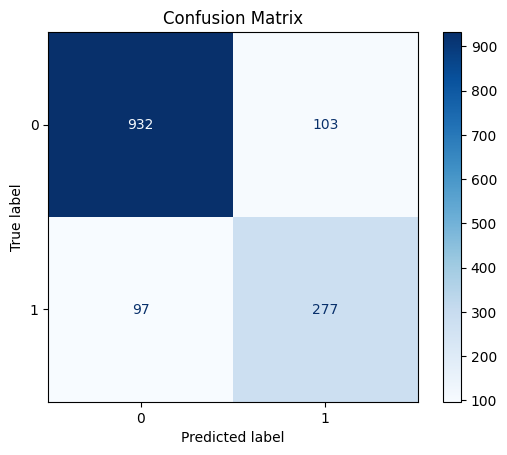

Final CatBoost Model Performance on Test Set
---------------------------------------------
Accuracy : 0.8581
Recall   : 0.7406
Precision: 0.7289
F1 Score : 0.7347
AUC      : 0.9130


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)
print("Final CatBoost Model Performance on Test Set")
print("---------------------------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")

In [17]:
def plot_importance(model, features, num=len(X_train_final), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})

    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)  # Điều chỉnh kích thước font chữ

    # Vẽ biểu đồ thanh
    ax = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])

    plt.title(f'Feature Importance - {model.__class__.__name__}')

    # Tăng khoảng cách giữa các nhãn bằng cách điều chỉnh khoảng cách trên trục y
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)  # Tăng kích thước font chữ của nhãn y
    ax.set_yticks(range(len(feature_imp)))  # Đảm bảo các tick trên trục y cách nhau đồng đều

    plt.tight_layout()
    plt.show(block=True)

    if save:
        plt.savefig(f'importances_{model.__class__.__name__}.png')

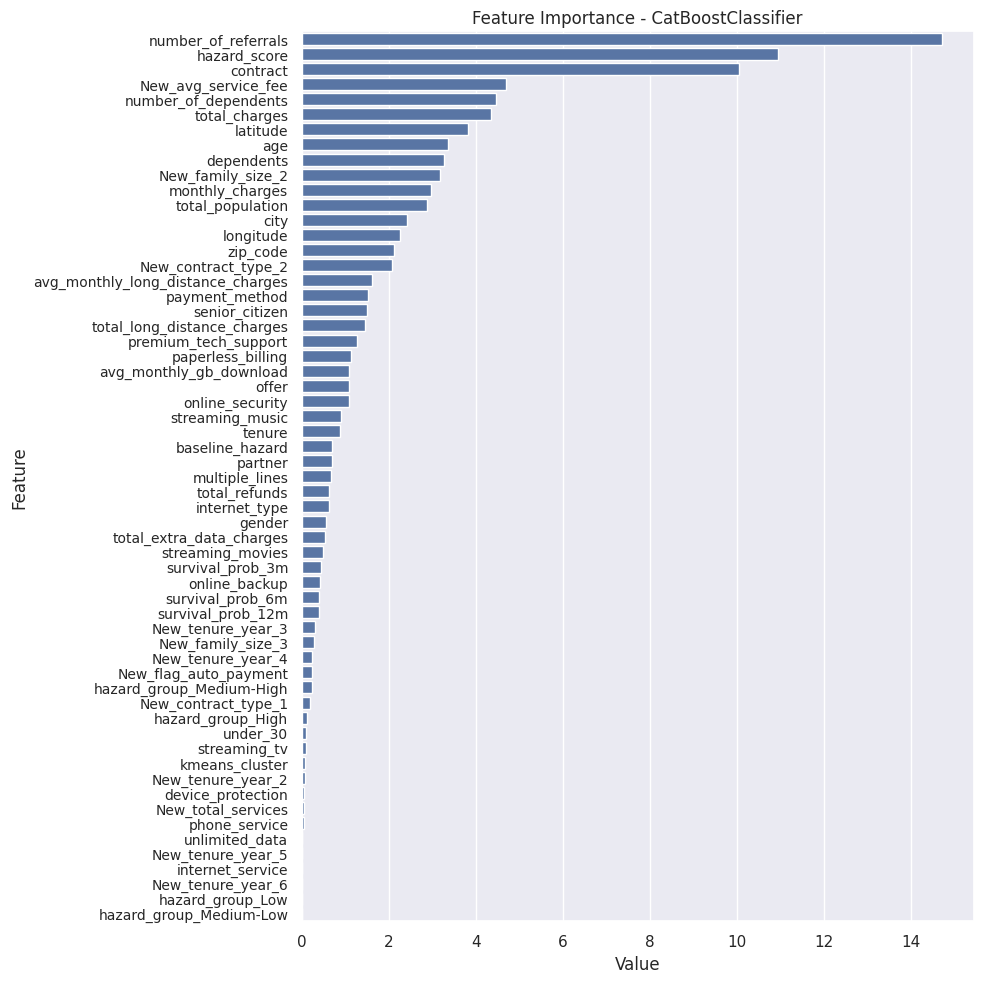

In [18]:
plot_importance(catboost_model, X_train_final)

In [19]:
X_train_final

,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,city,zip_code,total_population,latitude,longitude,New_total_services,New_flag_auto_payment,New_avg_service_fee,New_tenure_year_2,New_tenure_year_3,New_tenure_year_4,New_tenure_year_5,New_tenure_year_6,New_contract_type_1,New_contract_type_2,New_family_size_2,New_family_size_3,hazard_score,baseline_hazard,survival_prob_3m,survival_prob_6m,survival_prob_12m,hazard_group_High,hazard_group_Low,hazard_group_Medium-High,hazard_group_Medium-Low,kmeans_cluster
0,0,-0.071,0,0,1,0,0.000,60,1,1,1,0.083,1,2,2.667,1,1,0,0,0,1,1,2,0,1,1,0.437,-0.270,1.205,0.000,0.000,0.474,349,0.531,-0.369,0.400,-0.444,1,1,0.448,False,False,False,True,False,False,False,True,False,-0.617,2.112,-0.273,-0.153,-0.011,False,True,False,False,2
1,1,-0.071,0,0,0,1,3.000,12,0,1,0,-0.708,0,4,0.000,0,0,0,0,0,0,0,3,2,0,0,-0.938,-0.208,-0.349,0.000,0.000,-0.174,554,-1.080,0.870,-0.510,0.371,0,1,-0.859,False,False,False,False,False,False,True,True,False,-0.360,-0.027,0.666,0.765,0.828,False,False,False,True,0
2,0,-0.393,0,0,0,0,0.000,2,1,1,0,0.333,1,0,0.000,1,0,1,0,0,0,0,2,0,1,2,0.186,0.461,-0.371,0.000,0.000,-0.295,989,-0.016,-0.285,-0.160,-0.300,1,0,0.126,False,False,False,False,False,False,False,False,False,0.786,-0.030,0.816,0.977,1.208,True,False,False,False,1
3,1,-0.393,0,0,1,0,0.000,33,1,1,0,0.542,1,3,2.333,1,0,1,0,1,1,1,0,1,0,1,0.081,0.955,0.313,0.000,0.000,1.080,368,-0.717,0.706,-0.496,0.353,1,1,-0.008,False,True,False,False,False,True,False,True,False,-0.230,0.025,-0.161,-0.118,-0.010,False,False,False,True,2
4,0,0.250,0,0,0,1,1.000,14,1,1,1,0.208,1,4,0.000,1,0,0,1,0,0,0,2,0,1,3,0.288,0.913,-0.068,0.000,0.000,0.238,52,-0.029,-0.496,-0.244,-0.297,1,0,0.257,True,False,False,False,False,False,False,True,False,0.504,-0.025,0.616,0.721,0.722,True,False,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0,0.107,0,0,1,1,2.000,22,0,1,0,-0.708,0,0,2.667,0,0,0,0,0,0,0,3,1,0,0,-0.913,0.826,-0.278,0.000,0.000,0.532,952,-0.879,0.359,-0.576,0.419,0,1,-0.793,True,False,False,False,False,True,False,False,True,-0.506,-0.016,0.342,0.384,0.226,False,False,False,True,1
5630,0,-0.750,1,0,1,0,0.000,42,1,1,1,0.417,1,0,0.333,0,0,0,0,1,1,1,2,0,1,2,0.439,-0.590,0.824,0.000,0.000,-0.102,170,0.774,-0.513,1.179,-0.718,1,0,0.451,False,False,True,False,False,False,False,True,False,0.011,0.155,-0.272,-0.153,-0.011,False,False,True,False,2
5631,1,0.107,0,0,0,0,0.000,20,1,1,1,0.333,1,4,0.000,0,0,0,0,1,0,0,2,0,1,2,0.274,-0.792,0.100,0.000,0.000,-0.334,290,-0.554,0.375,-0.510,0.406,1,0,0.240,True,False,False,False,False,False,False,False,False,0.461,-0.020,0.439,0.464,0.334,True,False,False,False,2
5632,0,-0.143,0,0,1,1,3.000,24,0,1,1,-0.708,0,0,2.333,0,0,0,0,0,0,0,3,2,0,3,-0.840,-0.079,-0.243,0.000,0.000,0.086,363,0.780,-0.420,0.917,-0.676,0,0,-0.606,True,False,False,False,False,False,True,False,True,-0.710,-0.013,0.262,0.276,0.131,False,True,False,False,2


###  Xuất kmeans_model.pkl, catboost_model.pkl

In [20]:
import joblib
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(catboost_model, 'catboost_model.pkl')

['catboost_model.pkl']

## 30. Accelerated Failure Time in Training set

In [85]:
from google.colab import files
uploaded = files.upload()

merged_churn_data = pd.read_csv('Merged_Churn_Dataset.csv')

In [86]:
merged_churn_data

,customer_id,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,married,tenure,internet_service,phone_service,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,referred_a_friend,number_of_referrals,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,cltv,customer_status,churn_score,churn_label,churn_value,churn_category,churn_reason,country,state,city,zip_code,total_population,latitude,longitude
0,0002-ORFBO,Female,37,No,No,Yes,No,0,Yes,9,Yes,Yes,No,16,Yes,NaN,Yes,2,No,Yes,No,Yes,Yes,No,No,Cable,One Year,Yes,Mailed check,65.600,42.390,593.300,0.000,0,381.510,974.810,3,2205,Stayed,65,No,0,Not Applicable,NaN,United States,California,Frazier Park,93225,4498,34.828,-118.999
1,0003-MKNFE,Male,46,No,No,No,No,0,No,9,Yes,Yes,Yes,10,No,NaN,No,0,No,No,No,No,No,Yes,Yes,Cable,Month-to-Month,No,Mailed check,59.900,10.690,542.400,38.330,10,96.210,610.280,5,5414,Stayed,66,No,0,Not Applicable,NaN,United States,California,Glendale,91206,31297,34.163,-118.204
2,0004-TLHLJ,Male,50,No,No,No,No,0,No,4,Yes,Yes,No,30,Yes,Offer E,No,0,No,No,Yes,No,No,No,No,Fiber Optic,Month-to-Month,Yes,Electronic check,73.900,33.650,280.850,0.000,0,134.600,415.450,1,4479,Churned,71,Yes,1,Competitor,Competitor had better devices,United States,California,Costa Mesa,92627,62069,33.646,-117.923
3,0011-IGKFF,Male,78,No,Yes,Yes,No,0,Yes,13,Yes,Yes,No,4,Yes,Offer D,Yes,1,No,Yes,Yes,No,Yes,Yes,No,Fiber Optic,Month-to-Month,Yes,Electronic check,98.000,27.820,1237.850,0.000,0,361.660,1599.510,1,3714,Churned,91,Yes,1,Dissatisfaction,Product dissatisfaction,United States,California,Martinez,94553,46677,38.014,-122.115
4,0013-EXCHZ,Female,75,No,Yes,Yes,No,0,Yes,3,Yes,Yes,No,11,Yes,NaN,Yes,3,No,No,No,Yes,Yes,No,No,Fiber Optic,Month-to-Month,Yes,Mailed check,83.900,7.380,267.400,0.000,0,22.140,289.540,1,3464,Churned,68,Yes,1,Dissatisfaction,Network reliability,United States,California,Camarillo,93010,42853,34.228,-119.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,Yes,No,No,No,0,No,13,Yes,Yes,No,59,Yes,Offer D,No,0,Yes,No,No,Yes,No,No,Yes,DSL,One Year,No,Mailed check,55.150,46.680,742.900,0.000,0,606.840,1349.740,4,3161,Stayed,59,No,0,Not Applicable,NaN,United States,California,La Mesa,91941,44652,32.759,-116.997
7039,9992-RRAMN,Male,40,No,No,Yes,No,0,Yes,22,Yes,Yes,Yes,17,Yes,Offer D,Yes,1,No,No,No,No,No,Yes,Yes,Fiber Optic,Month-to-Month,Yes,Electronic check,85.100,16.200,1873.700,0.000,0,356.400,2230.100,1,5248,Churned,68,Yes,1,Dissatisfaction,Product dissatisfaction,United States,California,Riverbank,95367,16525,37.735,-120.954
7040,9992-UJOEL,Male,22,Yes,No,No,No,0,No,2,Yes,Yes,No,51,Yes,Offer E,No,0,No,Yes,No,No,No,No,No,DSL,Month-to-Month,Yes,Mailed check,50.300,18.620,92.750,0.000,0,37.240,129.990,5,5870,Joined,33,No,0,Not Applicable,NaN,United States,California,Elk,95432,383,39.108,-123.645
7041,9993-LHIEB,Male,21,Yes,No,Yes,No,0,Yes,67,Yes,Yes,No,58,Yes,Offer A,Yes,5,Yes,No,Yes,Yes,No,Yes,Yes,Cable,Two Year,No,Mailed check,67.850,2.120,4627.650,0.000,0,142.040,4769.690,3,4792,Stayed,59,No,0,Not Applicable,NaN,United States,California,Solana Beach,92075,12173,33.002,-117.264


In [106]:
# Xác định features (X) và target (y)
# Bỏ customer_id ngay từ đầu
X = merged_churn_data.drop(columns=['churn_value', 'customer_id'])
y = merged_churn_data['churn_value']
customer_ids = merged_churn_data['customer_id'] # Giữ lại để dùng sau

# Chia dữ liệu - QUAN TRỌNG: giữ lại index gốc
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Lấy customer_ids tương ứng cho train và test DÙNG INDEX GỐC
customer_ids_train = customer_ids.loc[X_train.index]
customer_ids_test = customer_ids.loc[X_test.index]

print("\n--- Sau khi chia Train/Test ---")
print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước X_test: {X_test.shape}")
print(f"Kích thước y_train: {y_train.shape}")
print(f"Kích thước y_test: {y_test.shape}")
print(f"Số lượng customer_ids_train: {len(customer_ids_train)}")
print(f"Số lượng customer_ids_test: {len(customer_ids_test)}")
print("\nIndex của X_train (ví dụ):", X_train.index[:5].tolist())
print("Index của y_train (ví dụ):", y_train.index[:5].tolist())
print("Index của customer_ids_train (ví dụ):", customer_ids_train.index[:5].tolist())


--- Sau khi chia Train/Test ---
Kích thước X_train: (5634, 49)
Kích thước X_test: (1409, 49)
Kích thước y_train: (5634,)
Kích thước y_test: (1409,)
Số lượng customer_ids_train: 5634
Số lượng customer_ids_test: 1409

Index của X_train (ví dụ): [3793, 3192, 4922, 3926, 3859]
Index của y_train (ví dụ): [3793, 3192, 4922, 3926, 3859]
Index của customer_ids_train (ví dụ): [3793, 3192, 4922, 3926, 3859]


In [107]:
# Tạo bản sao để tránh SettingWithCopyWarning
X_train = X_train.copy()

# Tạo nhãn lower bound (luôn là tenure)
X_train['label_lower_bound'] = X_train['tenure']

# Tạo nhãn upper bound
# Giá trị lớn nhất của tenure trong tập train (dùng làm giá trị thay thế cho Inf)
max_tenure_train = X_train['tenure'].max()

# Nếu churn (y_train == 1), upper_bound = tenure
# Nếu không churn (y_train == 0), upper_bound = max_tenure_train (censored)
X_train['label_upper_bound'] = X_train['tenure'].where(y_train == 1, max_tenure_train)

# Xử lý trường hợp đặc biệt: nếu lower == upper (churn ngay lập tức)
# Đặt upper_bound thành một giá trị rất nhỏ lớn hơn lower_bound một chút
# Hoặc giữ nguyên nếu mô hình/thư viện xử lý được (XGBoost AFT thường yêu cầu upper > lower)
# Cách tiếp cận an toàn là thêm một khoảng nhỏ
epsilon = 0.0000001
mask_immediate_churn = (y_train == 1) & (X_train['label_lower_bound'] == X_train['label_upper_bound'])
X_train.loc[mask_immediate_churn, 'label_upper_bound'] = X_train.loc[mask_immediate_churn, 'label_lower_bound'] + epsilon

# Kiểm tra một vài trường hợp
print("\n--- Nhãn Survival trên X_train ---")
print(X_train[['tenure', 'label_lower_bound', 'label_upper_bound']].head())
print("\nKiểm tra trường hợp churn (ví dụ):")
print(X_train.loc[y_train[y_train==1].index[:5], ['tenure', 'label_lower_bound', 'label_upper_bound']])
print("\nKiểm tra trường hợp không churn (ví dụ):")
print(X_train.loc[y_train[y_train==0].index[:5], ['tenure', 'label_lower_bound', 'label_upper_bound']])
print(f"Giá trị max_tenure_train dùng cho censored: {max_tenure_train}")


--- Nhãn Survival trên X_train ---
      tenure  label_lower_bound  label_upper_bound
3793      60                 60             72.000
3192      12                 12             72.000
4922       2                  2             72.000
3926      33                 33             72.000
3859      14                 14             72.000

Kiểm tra trường hợp churn (ví dụ):
      tenure  label_lower_bound  label_upper_bound
6953      35                 35             35.000
1035       1                  1              1.000
6398      13                 13             13.000
432       23                 23             23.000
1183       1                  1              1.000

Kiểm tra trường hợp không churn (ví dụ):
      tenure  label_lower_bound  label_upper_bound
3793      60                 60             72.000
3192      12                 12             72.000
4922       2                  2             72.000
3926      33                 33             72.000
3859      14       

In [108]:
print("\n--- Bắt đầu Tiền xử lý ---")

# Tách các cột label khỏi X_train TRƯỚC KHI xử lý features
# Đảm bảo chúng ta có bản sao gốc của labels với index gốc
train_labels_lower_orig = X_train.pop('label_lower_bound')
train_labels_upper_orig = X_train.pop('label_upper_bound')
print(f"Đã tách labels khỏi X_train. Kích thước X_train còn lại: {X_train.shape}")

# --- Tiếp tục xử lý features trên X_train (không còn labels) và X_test ---

# Ví dụ: Chọn cột số và cột phân loại (điều chỉnh nếu cần)
# Bây giờ không cần lo lắng về việc loại bỏ cột label nữa
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
survival_numeric_cols = ['hazard_score', 'baseline_hazard', 'survival_prob_3m', 'survival_prob_6m', 'survival_prob_12m']
numeric_cols = [col for col in numeric_cols if col not in survival_numeric_cols] # Loại bỏ cột survival nếu trùng

categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

# 1. Scaling cột survival (ví dụ RobustScaler) - Fit trên train, transform cả 2
if all(col in X_train.columns for col in survival_numeric_cols):
    scaler_survival = RobustScaler()
    X_train[survival_numeric_cols] = scaler_survival.fit_transform(X_train[survival_numeric_cols])
    if all(col in X_test.columns for col in survival_numeric_cols):
         X_test[survival_numeric_cols] = scaler_survival.transform(X_test[survival_numeric_cols])
    else:
        print("Cảnh báo: X_test thiếu cột survival để scale.")
else:
    print("Bỏ qua scaling cột survival do thiếu cột.") # Thông báo này bạn đã thấy


# One-Hot Encoding cột phân loại
cols_to_encode = categorical_cols.copy()
if 'hazard_group' in X_train.columns:
     cols_to_encode.append('hazard_group')
     numeric_cols = [col for col in numeric_cols if col != 'hazard_group'] # Đảm bảo không còn trong numeric

# Sử dụng pd.get_dummies
# Quan trọng: X_train và X_test bây giờ không còn cột label
X_train_encoded_intermediate = pd.get_dummies(X_train, columns=cols_to_encode, drop_first=True)
X_test_encoded_intermediate = pd.get_dummies(X_test, columns=cols_to_encode, drop_first=True)

# Căn chỉnh cột sau khi encoding (quan trọng!)
# Bây giờ align sẽ không loại bỏ cột label vì chúng đã được tách ra
X_train_aligned, X_test_aligned = X_train_encoded_intermediate.align(X_test_encoded_intermediate, join='inner', axis=1, fill_value=0)
print(f"Kích thước sau align: X_train_aligned={X_train_aligned.shape}, X_test_aligned={X_test_aligned.shape}")

# KMeans Clustering (Fit trên train, predict cả 2)
# Sử dụng các cột đã align (không có label)
common_cols_for_kmeans = X_train_aligned.columns.tolist() # Tất cả các cột sau align

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

# Fit và predict
kmeans.fit(X_train_aligned[common_cols_for_kmeans]) # Fit trên tất cả các cột chung
X_train_aligned['kmeans_cluster'] = kmeans.predict(X_train_aligned[common_cols_for_kmeans])
X_test_aligned['kmeans_cluster'] = kmeans.predict(X_test_aligned[common_cols_for_kmeans])
print("Đã thêm cột kmeans_cluster.")

# --- Kết thúc tiền xử lý features ---

# Bây giờ X_train_aligned và X_test_aligned chứa features đã xử lý, vẫn giữ index gốc
X_train_processed_features = X_train_aligned.copy()
X_test_processed_features = X_test_aligned.copy()

# **QUAN TRỌNG: Reset index cho features**
# Lưu index gốc để căn chỉnh labels sau này
original_train_index = X_train_processed_features.index
original_test_index = X_test_processed_features.index

X_train_processed_features = X_train_processed_features.reset_index(drop=True)
X_test_processed_features = X_test_processed_features.reset_index(drop=True)

# **Căn chỉnh lại Labels với index mới (0, 1, 2,...)**
# Sử dụng index gốc đã lưu để lấy đúng thứ tự labels
train_labels_lower = train_labels_lower_orig.loc[original_train_index].reset_index(drop=True)
train_labels_upper = train_labels_upper_orig.loc[original_train_index].reset_index(drop=True)

print("\n--- Sau khi Tiền xử lý Features & Reset Index & Căn chỉnh Labels ---")
print(f"Kích thước X_train_processed_features: {X_train_processed_features.shape}")
print(f"Kích thước X_test_processed_features: {X_test_processed_features.shape}")
print(f"Kích thước train_labels_lower (đã căn chỉnh): {train_labels_lower.shape}")
print(f"Kích thước train_labels_upper (đã căn chỉnh): {train_labels_upper.shape}")
print("\nIndex của X_train_processed_features (ví dụ):", X_train_processed_features.index[:5].tolist())
print("Index của train_labels_lower (ví dụ):", train_labels_lower.index[:5].tolist())

# Kiểm tra xem số cột features có khớp không
if X_train_processed_features.shape[1] != X_test_processed_features.shape[1]:
    print(f"CẢNH BÁO: Số cột features không khớp! Train={X_train_processed_features.shape[1]}, Test={X_test_processed_features.shape[1]}")


--- Bắt đầu Tiền xử lý ---
Đã tách labels khỏi X_train. Kích thước X_train còn lại: (5634, 49)
Bỏ qua scaling cột survival do thiếu cột.
Kích thước sau align: X_train_aligned=(5634, 766), X_test_aligned=(1409, 766)
Đã thêm cột kmeans_cluster.

--- Sau khi Tiền xử lý Features & Reset Index & Căn chỉnh Labels ---
Kích thước X_train_processed_features: (5634, 767)
Kích thước X_test_processed_features: (1409, 767)
Kích thước train_labels_lower (đã căn chỉnh): (5634,)
Kích thước train_labels_upper (đã căn chỉnh): (5634,)

Index của X_train_processed_features (ví dụ): [0, 1, 2, 3, 4]
Index của train_labels_lower (ví dụ): [0, 1, 2, 3, 4]


In [111]:
print("\n--- AFT trên Toàn bộ Tập Train (Huấn luyện) ---")

# ... (Phần tạo DMatrix và huấn luyện mô hình giữ nguyên) ...
# Tạo DMatrix cho toàn bộ tập train đã xử lý features
dtrain_full = xgb.DMatrix(X_train_processed_features)
dtrain_full.set_float_info('label_lower_bound', train_labels_lower)
dtrain_full.set_float_info('label_upper_bound', train_labels_upper)

# Tham số AFT
params_aft_full = {
    "objective": "survival:aft",
    "eval_metric": "aft-nloglik",
    "aft_loss_distribution": "normal",
    "aft_loss_distribution_scale": 1.20,
    "tree_method": "hist",
    "learning_rate": 0.05,
    "max_depth": 4
}

# Huấn luyện mô hình AFT trên TOÀN BỘ dữ liệu train
print("Bắt đầu huấn luyện AFT trên toàn bộ tập train...")
aft_model_full = xgb.train(
    params_aft_full,
    dtrain_full,
    num_boost_round=200
)
print("Huấn luyện hoàn thành.")

# --- PHẦN DỰ ĐOÁN VÀ HIỂN THỊ ĐÃ THAY ĐỔI ---
print("\n--- Dự đoán AFT CHỈ cho khách hàng CHƯA CHURN trên Tập Train ---")

# Xác định index (0, 1, 2,...) của khách hàng chưa churn
y_train_ordered = y_train.loc[original_train_index].reset_index(drop=True)
mask_train_not_churned_ordered = (y_train_ordered == 0)
print(f"Số lượng khách hàng chưa churn trong tập train: {mask_train_not_churned_ordered.sum()}")

# Lọc features và customer IDs của nhóm chưa churn
X_train_features_not_churned = X_train_processed_features[mask_train_not_churned_ordered]
customer_ids_train_ordered = customer_ids.loc[original_train_index].reset_index(drop=True)
customer_ids_train_not_churned = customer_ids_train_ordered[mask_train_not_churned_ordered]

assert len(X_train_features_not_churned) == len(customer_ids_train_not_churned), "Lỗi kích thước features và IDs chưa churn!"

# Tạo DMatrix mới CHỈ chứa features của nhóm chưa churn (KHÔNG cần set label)
dtrain_predict_only_not_churned = xgb.DMatrix(X_train_features_not_churned)

# Yêu cầu mô hình đã huấn luyện dự đoán trên DMatrix này
print(f"Bắt đầu dự đoán AFT cho {dtrain_predict_only_not_churned.num_row()} khách hàng chưa churn...")
predicted_time_train_not_churned = aft_model_full.predict(dtrain_predict_only_not_churned)
print("Dự đoán hoàn thành.")

# In kết quả dự đoán AFT cho nhóm này (Thêm thông tin Tenure)
print(f"\nKết quả dự đoán AFT cho khách hàng CHƯA CHURN trong tập train ({min(30, len(predicted_time_train_not_churned))} khách hàng đầu):")

# Kiểm tra xem cột 'tenure' có tồn tại không để tránh lỗi
if 'tenure' in X_train_features_not_churned.columns:
    for i, pred_time in enumerate(predicted_time_train_not_churned[:30]):
        customer_id = customer_ids_train_not_churned.iloc[i]
        # Lấy tenure từ DataFrame features đã lọc của nhóm chưa churn
        current_tenure = X_train_features_not_churned['tenure'].iloc[i]
        print(f"Khách hàng {customer_id} (Chưa churn, tenure: {current_tenure:.0f} tháng): Dự kiến churn sau khoảng {pred_time:.2f} tháng.")
else:
    print("CẢNH BÁO: Không tìm thấy cột 'tenure' trong dữ liệu đã xử lý để hiển thị.")
    # In kết quả mà không có tenure nếu cột bị thiếu
    for i, pred_time in enumerate(predicted_time_train_not_churned[:30]):
        customer_id = customer_ids_train_not_churned.iloc[i]
        print(f"Khách hàng {customer_id} (Chưa churn): Dự kiến churn sau khoảng {pred_time:.2f} tháng.")



--- AFT trên Toàn bộ Tập Train (Huấn luyện) ---
Bắt đầu huấn luyện AFT trên toàn bộ tập train...
Huấn luyện hoàn thành.

--- Dự đoán AFT CHỈ cho khách hàng CHƯA CHURN trên Tập Train ---
Số lượng khách hàng chưa churn trong tập train: 4139
Bắt đầu dự đoán AFT cho 4139 khách hàng chưa churn...
Dự đoán hoàn thành.

Kết quả dự đoán AFT cho khách hàng CHƯA CHURN trong tập train (30 khách hàng đầu):
Khách hàng 5334-JLAXU (Chưa churn, tenure: 60 tháng): Dự kiến churn sau khoảng 65.84 tháng.
Khách hàng 4573-JKNAE (Chưa churn, tenure: 12 tháng): Dự kiến churn sau khoảng 29.42 tháng.
Khách hàng 6923-JHPMP (Chưa churn, tenure: 2 tháng): Dự kiến churn sau khoảng 11.99 tháng.
Khách hàng 5524-KHNJP (Chưa churn, tenure: 33 tháng): Dự kiến churn sau khoảng 48.64 tháng.
Khách hàng 5433-KYGHE (Chưa churn, tenure: 14 tháng): Dự kiến churn sau khoảng 31.68 tháng.
Khách hàng 3831-YCPUO (Chưa churn, tenure: 72 tháng): Dự kiến churn sau khoảng 71.94 tháng.
Khách hàng 3794-NFNCH (Chưa churn, tenure: 30 tháng

## Xuất aft_model_full.pkl

In [110]:
with open("aft_model_full.pkl", "wb") as f:
  pickle.dump(aft_model_full, f)